# ДЗ 04. ML для бизнеса

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import os

/Users/artem/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Задание 1

Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [2]:
pwd

'/Users/artem/Movies/ML_buisness_course/hw/lesson04'

In [3]:
df = pd.read_csv('../../lesson4/my_PJME_MW.csv', index_col = [0], parse_dates = [0])#/Users/artem/Movies/ML_buisness_course/lesson4/my_PJME_MW.csv

Делаем ресемплинг и подчищаем датасет (удаляём столбец с часом, NaN-строки)

In [4]:
df_week = df.copy()
df_week = df_week.resample('W').mean()
df_week.dropna()
df_week = df_week.drop(columns=['hour'])
df_week.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,0.000000,0.000000,0.000000


Выводим на график:

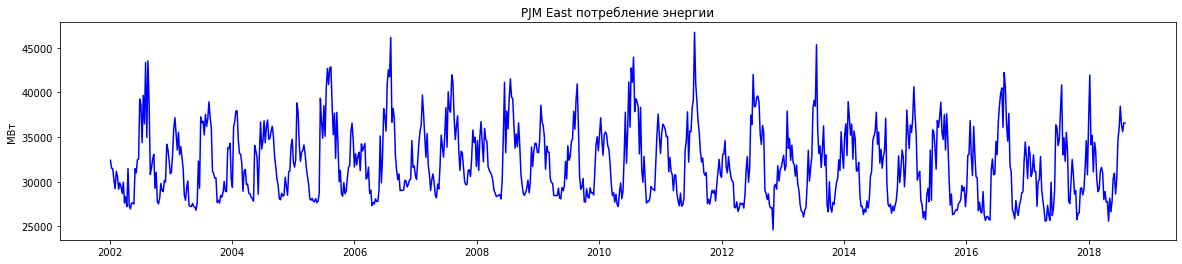

In [5]:
plt.figure(figsize =(20,4))
plt.plot( df_week.index, df_week['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

## Задание 2

Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

scl =StandardScaler()
scly =StandardScaler()

def split_data_b(data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b(df_week, '10-10-2016')

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
%%time
h=4
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df_week.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df_week.columns[0]].values[h:]

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)
#y_test_pred_gb = model_gb.predict(y_test_b)

CPU times: user 577 ms, sys: 12.2 ms, total: 589 ms
Wall time: 602 ms


KeyError: "None of [Int64Index([0], dtype='int64')] are in the [columns]"

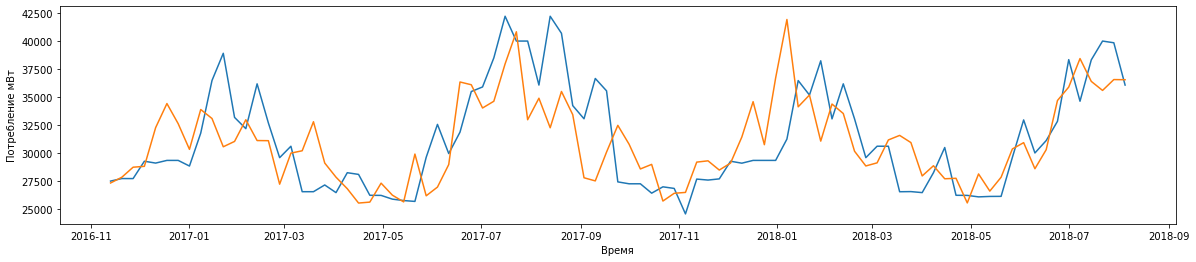

In [9]:
plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление мВт')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data +4 periods' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(test_b.index, test_b[[0]], label='исходный ряд')

plt.legend()
plt.show()

er_g4 = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

In [ ]:
test_b.iloc[:,0]

## Задание 3

Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков .

In [ ]:
%%time
h=1
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df_week.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df_week.columns[0]].values[h:]

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)


In [ ]:
plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление мВт')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data +1 period' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
#plt.plot(test_b.index, test_b[[0]], label='исходный ряд')

plt.legend()
plt.show()

er_g1 = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

In [ ]:
print(f'На горизонте 1 ошибка: {er_g1}%, на горизоне 4 ошибка: {er_g4}%')

## Задание 4

Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

### Создаём признаки

In [ ]:
# стандартизация данных
scl=StandardScaler()
X = df_week.iloc[:,:-1].values
Xscale = scl.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA

# создание двух признаков pca1, pca2
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
df_week['pca1']=Xpca[:,0]
df_week['pca2']=Xpca[:,1]

In [ ]:
# разница 1го порядка
first_diff =np.array(df_week.iloc[1:,0].values - df_week.iloc[:-1,0].values).astype('float32') 
df_week['diff1'] = 0
df_week['diff1'] =  df_week['diff1'].astype('float') 
df_week['diff1'].values[1:] = first_diff

In [ ]:
# скользящее среднее по 4м неделям (1 месяц)
df_week['4w']=df_week['PJME_MW'].rolling(window=4).mean()

In [ ]:
# EMA экспоненциальное скользящее среднее
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

df_week['exp_0_05'] = exponential_smoothing(df_week['PJME_MW'], 0.05)

Визуализиуем новые признаки:

In [ ]:
N100=200
plt.plot(df_week.index[:N100],df_week['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(df_week.index[:N100],df_week['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(df_week.index[:N100],df_week['4w'][:N100],'--b',label ='скользящее среднее 4 нед.')
plt.plot(df_week.index[:N100],df_week['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

In [ ]:
# экспоненциальные скользящие средние
df_week['exp_0_02'] = exponential_smoothing(df_week['PJME_MW'], 0.02)
df_week['exp_0_08'] = exponential_smoothing(df_week['PJME_MW'], 0.08)

N100=400
plt.plot(df_week.index[:N100],df_week['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(df_week.index[:N100],df_week['exp_0_02'][:N100],'--g',label ='экспоненциальное среднее')
plt.plot(df_week.index[:N100],df_week['exp_0_05'][:N100],'--b',label ='экспоненциальное среднее')
plt.plot(df_week.index[:N100],df_week['exp_0_08'][:N100],'--k',label ='экспоненциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [ ]:
df_week = df_week.dropna()

Добавим истории длиной p в признаках автокорреляции

In [ ]:
p = 4
for i in range(p):
    df_week['t'+str(p-i)]=0
    df_week['t'+str(p-i)].values[p:] = df_week['PJME_MW'].values[i:-(p)+i]

добавляем первые разности на глубину p

In [ ]:
p = 4
for i in range(p):
    df_week['d'+str(p-i)]=0
    df_week['d'+str(p-i)].values[p:] = df_week['diff1'].values[i:-(p)+i]

In [ ]:
# Итоговая система признаков
pd.options.display.max_columns = None
df_week

### Выделение существенных признаков

In [ ]:
scl_target=StandardScaler() 
# p = 4
h=4
target = df_week['PJME_MW'].values[h+p:].reshape((df_week.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

In [ ]:
scl_x=StandardScaler() 

X = df_week.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [ ]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

In [ ]:
column_names = df_week.columns[sfk.get_support()]
column_names

Лучшее множество признаков отделено в X_new1

### Разделение данных на тестовые и тренировочные 

In [ ]:
# сделаем функцию разбиения на трейн и тест выборки
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

назначим датой разделения 1/06/2016

In [ ]:
train, test = split_data(df_week, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [ ]:
X_train =X_new1[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new1[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [ ]:
X_new1

### Строим Модель

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model_g = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

In [ ]:
model_g.fit( X_train, y_train ) # 

In [ ]:
y_test_pred_g = model_g.predict(X_test)

In [ ]:
h = 4
h_list = []
X_train_b = train.iloc[:-h,:]
y_train_b = train[df_week.columns[0]].values[h:]
X_test_b = test.iloc[:-h,:]
y_test_b = test[df_week.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

er_g_ = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

item = {'h_value':h, 'MAPE':er_g_}
print(item)

In [ ]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

**Оценки для сравнения моделей**

Оценим промах модели, используя метрики, которые можно применять для оценки регрессий https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:
- средне-квадратичное отклонение
- среднюю абсолютную ошибку
- коэфиициент детерминации 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

### Использование рекурсивной модели для предсказания n*h моментов времени

In [ ]:
n = 4

In [ ]:
#['PJME_MW', '4w', 't1', 'd3', 'd2']
X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()
N10 = n
for i in range(N10):
    y_test_100[i] = model_g.predict(X_test_100[i,:].reshape((1,5)))
    
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = y_test_100[i]
#     X_test_100[i+1,1] = 0#y_test_100[i]
#     X_test_100[i+1,2] = 0#y_test_100[i]
#     X_test_100[i+1,3] = 0#y_test_100[i]
#     X_test_100[i+1,4] = 0#y_test_100[i]
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()    

In [ ]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[:N10]),y_pred = scl_target.inverse_transform( y_test_100[:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

**Вывод: MAPE рекурсивного метода 40%, а g-boost 10%**

### Задание 5

Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

In [ ]:
#['PJME_MW', '4w', 't1', 'd3', 'd2']
X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()
N10 = 100
av_mapes = []
for i1 in range(10):
    av_mape = 0
    for i2 in range(10):
        y_test_100[i1*10+i2] = model_g.predict(X_test_100[i1*10+i2,:].reshape((1,5)))

        # заполняем вектор для прогноза следующей точки
        X_test_100[i1*10+i2+1,0] = y_test_100[i]
        
        er_mape = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[:N10]),y_pred = scl_target.inverse_transform( y_test_100[:N10]))
        av_mape = av_mape + (er_mape/(i2+1))
        
        
    item = {'from':i1*10, 'up_to':i1*10+10, 'mape':av_mape}
    av_mapes.append(item)
    print(item)
    #print(f'from {i1*10} to {i1*10+10} MAPE is: {av_mape}')    

In [ ]:
mapes_df = pd.DataFrame(av_mapes)
mapes_df

In [ ]:
plt.xlabel('periods in horizont')
plt.ylabel('MAPE')
plt.plot(mapes_df['up_to'],mapes_df['mape'], 'r',label='predict GB data' )
plt.legend()
plt.show()  

### Задание 6

Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Ошибка предсказания растёт с увеличением горизонта предсказания. Рост ошибки линейный, и, что кажется удивительным (возможно, у меня где-то ошибка), растёт совсем не так, как я бы мог ожидать: При увеличении горизонта предсказания с 10 дней до 50 (в пять раз!) ошибка вырастает всего на 10%! Для меня пока это удивительно, хотя, вероятно, где-то ошибка